In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import BSpline, splev, interp1d
plt.rcParams['font.size'] = 10.5

In [2]:
def getH(x):
    """Computes the Hubble parameter H given some x"""
    return H0*np.sqrt((Ωb + Ωm)*np.exp(-3.0*x) + Ωr*np.exp(-4.0*x) + ΩΛ)

def getHPrime(x):
    """Function for H prime e.g. H' = aH"""
    return H0*np.sqrt((Ωb + Ωm)*np.exp(-x) + Ωr*np.exp(-2.0*x) + ΩΛ*np.exp(2.0*x))

def getdHPrime(x):
    return .5*np.exp(x)*H0*(-(Ωb + Ωm)*np.exp(2.0*x) - 2.0*Ωr*np.exp(-3.0*x) + 2.0*ΩΛ*np.exp(x))/np.sqrt( ((Ωb + Ωm)/np.exp(x)) + Ωr*np.exp(-2.0*x) + ΩΛ*np.exp(2.0*x))

def ηDeriv(t, x):
    """Called by odeint when solving for the conformal time eta"""
    return c/getHPrime(x)

def getη(x):
    """Interpolates a value from the differential equation
     solution η using values from the x_grid array"""
    return η_spline(x)

def getΩb(x):
    """Computes the value of the baryon density parameter (omega_b) at some x"""
    return Ωb*np.exp(-3.0*x)*((H0/getH(x))**2.0)

def getΩm(x):
    """Computes the dark matter density parameter (omega_m) at x"""
    return Ωm*np.exp(-3.0*x)*((H0/getH(x))**2.0)

def getΩr(x):
    """Computes radiation density (omega_r) at x"""
    return Ωr*np.exp(-4.0*x)*((H0/getH(x))**2.0)

def getΩΛ(x):
    """Computes the dark energy parameter (omega_lambda) at x;
     it is the difference between 1 and the sum of the other parameters"""
    return 1.0 - (getΩb(x) + getΩm(x) + getΩr(x))

In [67]:
H0 = 2.268543540763823e-18   # Hubble's constant: [1/s], H0/m2Mpc/1000 = 70 (km/s)/Mpc
c  = 2.99792458e8            # Speed of light: [m/s]
Ωb = 0.046
Ωm = 0.224
Ωr = 8.3e-5
ΩΛ = 1.0 - Ωb - Ωm - Ωr
m2Mpc = 3.24078e-23

spline_order = 3

n_grid = 1000

ainit = 1.0e-8
aend = 1.0

xstart = np.log(ainit)
x_end = np.log(aend)

x_grid = np.linspace(xstart, x_end, n_grid, endpoint=True)

η_ini = c/getHPrime(xstart)
η = odeint(ηDeriv, η_ini, x_grid)

η_spline = BSpline(x_grid, η, k=spline_order)

η_grid = np.zeros(n_grid)
hubble = np.zeros(n_grid)
Ωb_grid = np.zeros(n_grid)
Ωm_grid = np.zeros(n_grid)
Ωr_grid = np.zeros(n_grid)
ΩΛ_grid = np.zeros(n_grid)
hubblep = np.zeros(n_grid)

for i in range(len(x_grid)):
    η_grid[i] = getη(x_grid[i])
    hubble[i] = getH(x_grid[i])
    hubblep[i] = getHPrime(x_grid[i])
    Ωb_grid[i] = getΩb(x_grid[i])
    Ωm_grid[i] = getΩm(x_grid[i])
    Ωr_grid[i] = getΩr(x_grid[i])
    ΩΛ_grid[i] = getΩΛ(x_grid[i])

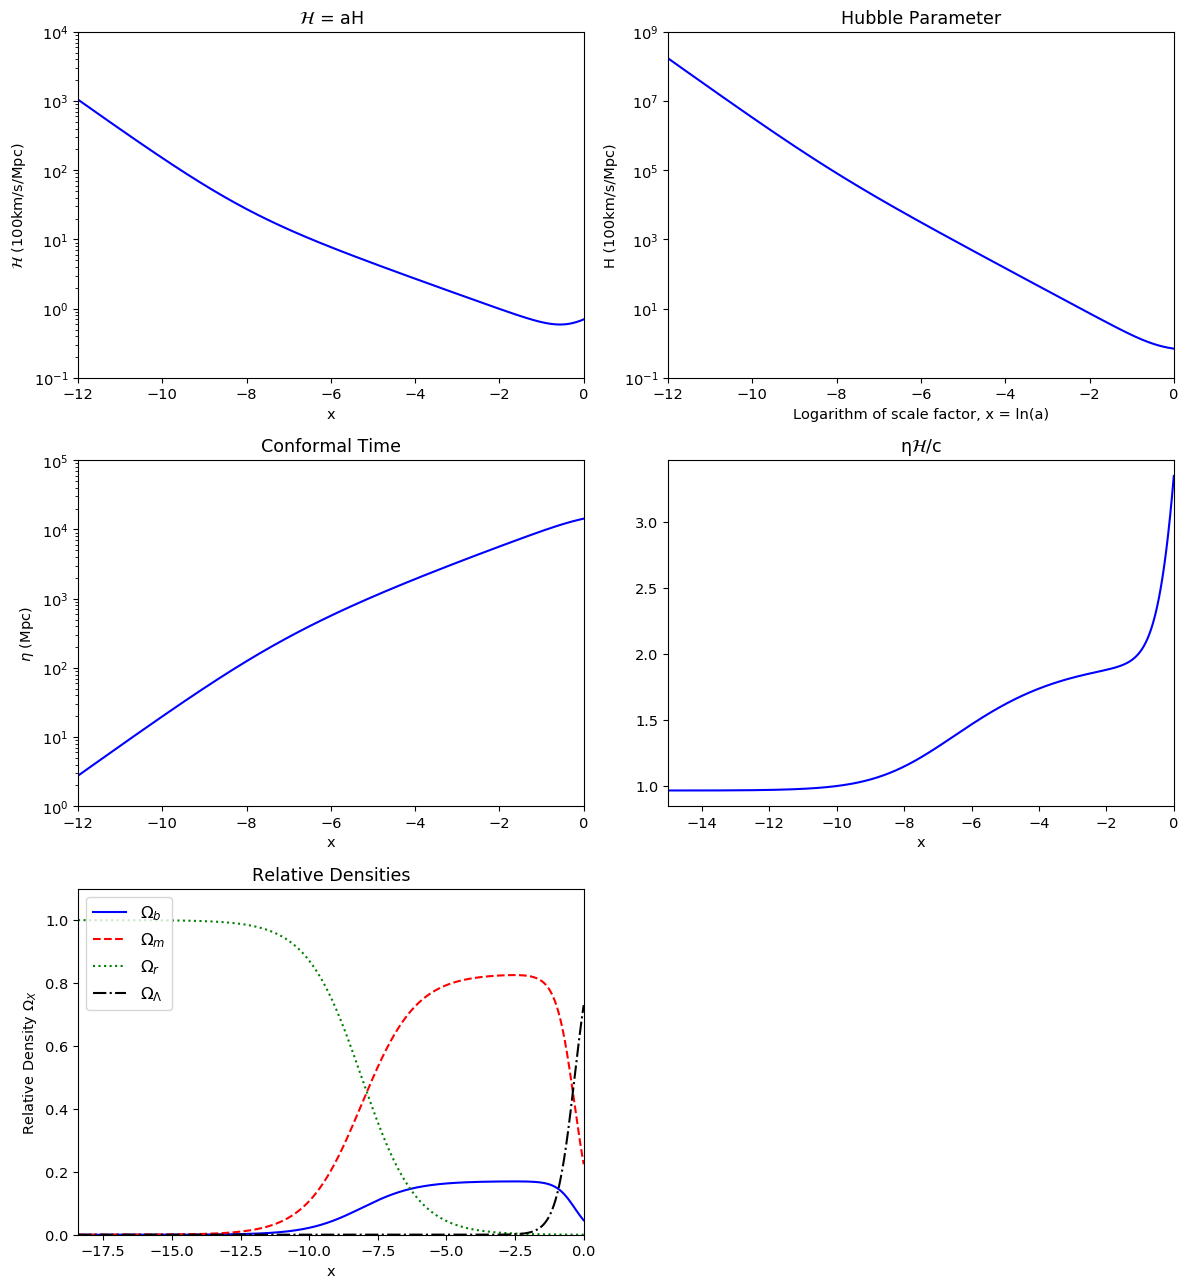

In [68]:
'''
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 13), dpi=100)

axs[0, 0].plot(x_grid, hubblep/m2Mpc/1000.0/100.0, 'b')
axs[0, 0].set_xlim(-12, 0)
axs[0, 0].set_ylim(1.0e-1, 1.0e4)
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('$\mathcal{H}$ = aH')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('$\mathcal{H}$ (100km/s/Mpc)')


axs[0, 1].plot(x_grid, hubble/m2Mpc/1000.0/100.0, 'b')
axs[0, 1].set_xlim(-12, 0)
axs[0, 1].set_ylim(1.0e-1, 1.0e9)
axs[0, 1].set_yscale('log')
axs[0, 1].set_title('Hubble Parameter')
axs[0, 1].set_xlabel('Logarithm of scale factor, x = ln(a)')
axs[0, 1].set_ylabel('H (100km/s/Mpc)')


axs[1, 0].plot(x_grid, η_grid*m2Mpc, 'b')
axs[1, 0].set_xlim(-12, 0)
axs[1, 0].set_ylim(1.0e0, 1.0e5)
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Conformal Time')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel("$\eta$ (Mpc)")


axs[1, 1].plot(x_grid, η_grid*hubblep/c, 'b')
axs[1, 1].set_xlim(-15, 0)
#axs[1,1].set_ylim(.85, 3.3)
axs[1, 1].set_title('η$\mathcal{H}$/c')
axs[1, 1].set_xlabel('x')


axs[2, 0].plot(x_grid, Ωb_grid, color='blue')
axs[2, 0].plot(x_grid, Ωm_grid, ls='--', color='red')
axs[2, 0].plot(x_grid, Ωr_grid, ls=':', color='green')
axs[2, 0].plot(x_grid, ΩΛ_grid, ls='-.', color='black')
axs[2, 0].set_xlim(xstart, 0.0)
axs[2, 0].set_ylim(0.0, 1.1)
axs[2, 0].set_title('Relative Densities')
axs[2, 0].set_xlabel('x')
axs[2, 0].set_ylabel('Relative Density $\Omega_X$')
axs[2, 0].legend(['$\Omega_b$', '$\Omega_m$', '$\Omega_r$', '$\Omega_\Lambda$'], loc='upper left', prop={'size':12})


axs[2, 1].remove()

fig.tight_layout()
#plt.savefig('background-cosmology')
plt.show()
'''